In [ ]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Gin Rummy

In [ ]:
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

In [ ]:
all_classes = ['SP0','SP1','Draw','Pickup','DH','GIN',
               'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
               'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
               'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD',
               'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC',
               'AS', '2S', '3S', '4S', '5S', '6S', '7S', '8S', '9S', 'TS', 'JS', 'QS', 'KS',
               'AH', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', 'TH', 'JH', 'QH', 'KH',
               'AD', '2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', 'TD', 'JD', 'QD', 'KD',
               'AC', '2C', '3C', '4C', '5C', '6C', '7C', '8C', '9C', 'TC', 'JC', 'QC', 'KC']


## Imports

In [ ]:
#-------------------------------------------------------------------------------
# The following code was originally written by Todd Neller in Java.
# It was translated into Python by Anthony Hein.
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# A class for modeling a game of Gin Rummy
# @author Todd W. Neller
# @version 1.0
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Copyright (C) 2020 Todd Neller
#
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Information about the GNU General Public License is available online at:
#   http://www.gnu.org/licenses/
# To receive a copy of the GNU General Public License, write to the Free
# Software Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA
# 02111-1307, USA.
#-------------------------------------------------------------------------------

import random
import time
import numpy as np
import os
import torch

%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy

from Deck import Deck
from GinRummyUtil import GinRummyUtil
from SimpleGinRummyPlayer import SimpleGinRummyPlayer

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from models import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis
#-------------------------------------------------------------------------------

# TRACKING
# Plane (5x52)      Feature
# 0	 currHand       the cards in current player's hand
# 1	 topCard        the top card of the discard pile
# 2	 deadCard       the dead cards: cards in discard pile (excluding the top card)
# 3	 oppCard        opponent known cards: cards picked up from discard pile, but not discarded
# 4	 unknownCard    the unknown cards: cards in stockpile or in opponent hand (but not known)

# Action ID         Action
# 0	                score_player_0_action
# 1	                score_player_1_action
# 2	                draw_card_action
# 3	                pick_up_discard_action
# 4	                declare_dead_hand_action
# 5	                gin_action
# 6 - 57	        discard_action
# 58 - 109	        knock_action

# Knock_bin
# Action ID         Action
# 0	                No Knock
# 1	                Knock

def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    suitNames = ['S', 'H', 'D', 'C']
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret

#-------------------------------------------------------------------------------

/content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis


## MLPGinRummyPlayer

In [ ]:
# -------------------------------------------------------------------------------
#  MLPGinRummyPlayer
#
#  This estimation will be calculated using a Multilayer Percepton trained on the
#  SimpleGinRummyPlayer written
#  by Calvin Tan.
#
#  @author Calvin Tan
#  @version 1.0
# -------------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# The following code was originally written by Todd Neller in Java.
# It was translated into Python by May Jiang.
# -------------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# Copyright (C) 2020 Todd Neller
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# Information about the GNU General Public License is available online at:
#   http://www.gnu.org/licenses/
# To receive a copy of the GNU General Public License, write to the Free
# Software Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA
# 02111-1307, USA.
# -------------------------------------------------------------------------------

from typing import List, TypeVar
from random import randint
from GinRummyUtil import GinRummyUtil
from GinRummyPlayer import GinRummyPlayer

# Import MLP Models
# from SupervisedLearning.models import *

Card = TypeVar('Card')

class MLPGinRummyPlayer(GinRummyPlayer):

    def loadModel(self, model_pt):
        print('Load Model')
        self.model = model_pt

    def setVerbose(self, verbose):
        self.playVerbose = verbose

    def updateStates(self, states):
        if self.playVerbose:
            print('Update States')
        self.state = states

    def knockAction(self) -> bool:
        return self.knock

    # Inform player of 0-based player number (0/1), starting player number (0/1), and dealt cards
    def startGame(self, playerNum: int, startingPlayerNum: int, cards: List[Card]) -> None:
        self.playerNum = playerNum
        self.startingPlayerNum = startingPlayerNum
        self.cards = list(cards)
        self.opponentKnocked = False
        self.drawDiscardBitstrings = [] # long[], or List[int]
        self.faceUpCard = None
        self.faceUpCardBool = False
        self.drawnCard = None
        self.state = None
        self.knock = False
        self.playVerbose = False

    # Return whether or not player will draw the given face-up card on the draw pile.
    def willDrawFaceUpCard(self, card: Card) -> bool:
        self.faceUpCard = card
        # BPBD, either draw(2)->False or pickup(3)->True
        state = np.expand_dims(self.state, axis=0)
        state = torch.from_numpy(state).type(torch.FloatTensor).to(device)
        action = self.model(state)
        action = action.detach().numpy().reshape(-1)
        if self.playVerbose:
            print('Draw new card:', action[2])
            print('Pickup from discard:', action[3])
        if action[3] > action[2]:
            # print('Pickup Discard Action')
            self.faceUpCardBool = True
            return True
        # print('Draw from Deck Action')
        self.faceUpCardBool = False
        return False

    # Report that the given player has drawn a given card and, if known, what the card is.
    # If the card is unknown because it is drawn from the face-down draw pile, the drawnCard is null.
    # Note that a player that returns false for willDrawFaceUpCard will learn of their face-down draw from this method.
    def reportDraw(self, playerNum: int, drawnCard: Card) -> None:
        # Ignore other player draws.  Add to cards if playerNum is this player.
        if playerNum == self.playerNum:
            self.cards.append(drawnCard)
            self.drawnCard = drawnCard






    # def getDiscard(self) -> Card:
    #     # Discard a random card (not just drawn face up) leaving minimal deadwood points.
    #     minDeadwood = float('inf')
    #     candidateCards = []
    #     for card in self.cards:
    #         # Cannot draw and discard face up card.
    #         if card == self.drawnCard and self.drawnCard == self.faceUpCard:
    #         # if card == self.drawnCard and self.faceUpCard:
    #             continue
    #         # Disallow repeat of draw and discard.
    #         drawDiscard = [self.drawnCard, card]
    #         if GinRummyUtil.cardsToBitstring(drawDiscard) in self.drawDiscardBitstrings:
    #             continue

    #         remainingCards = list(self.cards)
    #         remainingCards.remove(card)
    #         bestMeldSets = GinRummyUtil.cardsToBestMeldSets(remainingCards)
    #         deadwood = GinRummyUtil.getDeadwoodPoints3(remainingCards) if len(bestMeldSets) == 0 \
    #             else GinRummyUtil.getDeadwoodPoints1(bestMeldSets[0], remainingCards)
    #         if deadwood <= minDeadwood:
    #             if deadwood < minDeadwood:
    #                 minDeadwood = deadwood
    #                 candidateCards.clear()
    #             candidateCards.append(card)
    #     # Prevent future repeat of draw, discard pair.
    #     discard = candidateCards[randint(0, len(candidateCards)-1)]
    #     drawDiscard = [self.drawnCard, discard]
    #     self.drawDiscardBitstrings.append(GinRummyUtil.cardsToBitstring(drawDiscard))
    #     return discard

    # Get the player's discarded card.  If you took the top card from the discard pile,
    # you must discard a different card.
    # If this is not a card in the player's possession, the player forfeits the game.
    # @return the player's chosen card for discarding
    def getDiscard(self) -> Card:
        # APBD, either either discard or knock...
        # determine the allowable actions (which cards can be discarded/knocked on)
        currHand = np.array(self.state[0:52])
        knockCards = np.array(self.state[0:52])
        # if self.playVerbose:
        #     print('Current Hand:', un_one_hot(currHand))
        # disallow discarding PickUp FaceUp/Discarded Card
        if self.faceUpCardBool:
        # if self.drawnCard == self.faceUpCard:
            currHand[self.drawnCard.getId()] = 0
            knockCards[self.drawnCard.getId()] = 0
        
        # prune illegal knock actions
        cardIndex = np.where(knockCards == 1)[0]
        for c in cardIndex:
            remainingCards = list(self.cards)
            remainingCards.remove(Deck.getCard(c))
            bestMeldSets = GinRummyUtil.cardsToBestMeldSets(remainingCards)
            deadwood = GinRummyUtil.getDeadwoodPoints3(remainingCards) if len(bestMeldSets) == 0 \
                else GinRummyUtil.getDeadwoodPoints1(bestMeldSets[0], remainingCards)
            if deadwood > 10:
                knockCards[c] = 0

        state = np.expand_dims(self.state, axis=0)
        state = torch.from_numpy(state).type(torch.FloatTensor).to(device)
        action = self.model(state)
        action = action.detach().numpy().reshape(-1)

        discardMax = max(currHand * action[6:58])
        # knockMax = max(currHand * action[58:110])
        knockMax = max(knockCards * action[58:110])

        if self.playVerbose:
            unmeldedCards = self.cards.copy()
            bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
            if len(bestMelds) > 0:
                melds = bestMelds[0]
                for meld in melds:
                    for card in meld:
                        unmeldedCards.remove(card)
                melds.extend(unmeldedCards)
            else:
                melds = unmeldedCards
            print('Current Hand:', melds)
            if np.argmax(action) > 58:
                # print('Knock', all_classes[np.argmax(action)], '| D:', Deck.getCard(np.argmax(currHand * action[6:58])), '| K:', Deck.getCard(np.argmax(currHand * action[58:])), '|', np.argmax(action))
                print('Knock', all_classes[np.argmax(action)], '| D:', Deck.getCard(np.argmax(currHand * action[6:58])), '| K:', Deck.getCard(np.argmax(knockCards * action[58:])), '|', np.argmax(action))
            else:
                # print('Discard', all_classes[np.argmax(action)], '| D:', Deck.getCard(np.argmax(currHand * action[6:58])), '| K:', Deck.getCard(np.argmax(currHand * action[58:])), '|', np.argmax(action))
                print('Discard', all_classes[np.argmax(action)], '| D:', Deck.getCard(np.argmax(currHand * action[6:58])), '| K:', Deck.getCard(np.argmax(knockCards * action[58:])), '|', np.argmax(action))
            print('MAX:{:.4f}, {:.4f}'.format(discardMax, knockMax))

        if discardMax > knockMax or int(sum(knockCards) == 0):
            if self.playVerbose:
                print('Discard Action')
            self.knock = False
            return Deck.getCard(np.argmax(currHand * action[6:58]))
        else:
            if self.playVerbose:
                print('Knock Action')
            self.knock = True
            # return Deck.getCard(np.argmax(currHand * action[58:]))
            return Deck.getCard(np.argmax(knockCards * action[58:]))




















    # Report that the given player has discarded a given card.
    def reportDiscard(self, playerNum: int, discardedCard: Card) -> None:
        # Ignore other player discards.  Remove from cards if playerNum is this player.
        if playerNum == self.playerNum:
            self.cards.remove(discardedCard)

    # At the end of each turn, this method is called and the player that cannot (or will not) end the round will return a null value.
    # However, the first player to "knock" (that is, end the round), and then their opponent, will return an ArrayList of ArrayLists of melded cards.
    # All other cards are counted as "deadwood", unless they can be laid off (added to) the knocking player's melds.
    # When final melds have been reported for the other player, a player should return their final melds for the round.
    # @return null if continuing play and opponent hasn't melded, or an ArrayList of ArrayLists of melded cards.
    def getFinalMelds(self) -> List[List[Card]]:
        # Check if deadwood of maximal meld is low enough to go out.
        bestMeldSets = GinRummyUtil.cardsToBestMeldSets(self.cards) # List[List[List[Card]]]
        if not self.opponentKnocked and (len(bestMeldSets) == 0 or \
            GinRummyUtil.getDeadwoodPoints1(bestMeldSets[0], self.cards) > \
            GinRummyUtil.MAX_DEADWOOD):
            return None
        if len(bestMeldSets) == 0:
            return []
        return bestMeldSets[randint(0, len(bestMeldSets)-1)]

    # When an player has ended play and formed melds, the melds (and deadwood) are reported to both players.
    def reportFinalMelds(self, playerNum: int, melds: List[List[Card]]) -> None:
        # Melds ignored by simple player, but could affect which melds to make for complex player.
        if playerNum != self.playerNum:
            self.opponentKnocked = True

    # Report current player scores, indexed by 0-based player number.
    def reportScores(self, scores: List[int]) -> None:
        # Ignored by simple player, but could affect strategy of more complex player.
        return

    # Report layoff actions.
    def reportLayoff(self, playerNum: int, layoffCard: Card, opponentMeld: List[Card]) -> None:
        # Ignored by simple player, but could affect strategy of more complex player.
        return

    # Report the final hands of players.
    def reportFinalHand(self, playerNum: int, hand: List[Card]) -> None:
        # Ignored by simple player, but could affect strategy of more complex player.
        return

### Estimator Network & load checkpoint

In [ ]:
class EstimatorNetwork(nn.Module):
    ''' The function approximation network for Estimator
        It is just a series of sigmoid layers. All in/out are torch.tensor
        (OLD) It is just a series of tanh layers. All in/out are torch.tensor
    '''

    def __init__(self, mlp_layers=None, batch_norm=False, knock_layer=False, top_layer=True):
        ''' Initialize the Q network
        Args:
            action_num (int): number of legal actions
            state_shape (list): shape of state tensor
            mlp_layers (list): output size of each fc layer
        '''
        super(EstimatorNetwork, self).__init__()

        self.action_num = 110
        self.state_shape = 260
        self.mlp_layers = mlp_layers
        self.batch_norm = batch_norm
        self.knock_layer = knock_layer
        self.top_layer = top_layer

        # build the Q network
        layer_dims = [np.prod(self.state_shape)] + self.mlp_layers
        fc = [nn.Flatten()]
        if batch_norm:
            fc.append(nn.BatchNorm1d(layer_dims[0]))
        for i in range(len(layer_dims)-1):
            fc.append(nn.Linear(layer_dims[i], layer_dims[i+1], bias=True))
            fc.append(nn.Sigmoid())
        # add top layer onto Q-network
        if self.top_layer:
            fc.append(nn.Linear(layer_dims[-1], self.action_num, bias=True))
            fc.append(nn.Softmax(dim=1))
        else:
            # remove last sigmoid layer and append softmax layer
            fc.pop()
            fc.append(nn.Softmax(dim=1))

        # add knock layer to be an additional layer, which will manually be set identity
        # with bias on the knock actions (58-110)
        # required to be frozen!!!
        if self.knock_layer:
            fc.append(nn.Linear(self.action_num, self.action_num, bias=True))
            fc.append(nn.Softmax(dim=1))
        self.fc_layers = nn.Sequential(*fc)
        
    def forward(self, s):
        ''' Predict action values
        Args:
            s  (Tensor): (batch, state_shape)
        '''
        return self.fc_layers(s)

In [ ]:
def load_checkpoint(checkpoint):
    pretrained_dict = {}
    if knock_layer:
        pretrained_dict = checkpoint
    else:
        model_dict = checkpoint
        # check if there is batch norm layer
        if batch_norm:
            b_layer = 1 
            pretrained_dict['fc_layers.1.weight'] = model_dict['fc_layers.1.weight']
            pretrained_dict['fc_layers.1.bias'] = model_dict['fc_layers.1.bias']
            pretrained_dict['fc_layers.1.running_mean'] = model_dict['fc_layers.1.running_mean']
            pretrained_dict['fc_layers.1.running_var'] = model_dict['fc_layers.1.running_var']
            pretrained_dict['fc_layers.1.num_batches_tracked'] = model_dict['fc_layers.1.num_batches_tracked']
        else:
            b_layer = 0
        curr_layer = 1 + b_layer
        for i in range(len(mlp_layers)):
            pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['fc_layers.{}.weight'.format(curr_layer)]
            pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['fc_layers.{}.bias'.format(curr_layer)]
            curr_layer += 2
        if top_layer:
            pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['fc_layers.{}.weight'.format(curr_layer)]
            pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['fc_layers.{}.bias'.format(curr_layer)]
    return pretrained_dict

## RandGinRummyPlayer

In [ ]:
# -------------------------------------------------------------------------------
#  RandGinRummyPlayer
#
#  This estimation will be calculated using a Multilayer Percepton trained on the
#  SimpleGinRummyPlayer written
#  by Calvin Tan.
#
#  @author Calvin Tan
#  @version 1.0
# -------------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# The following code was originally written by Todd Neller in Java.
# It was translated into Python by May Jiang.
# -------------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# Copyright (C) 2020 Todd Neller
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# Information about the GNU General Public License is available online at:
#   http://www.gnu.org/licenses/
# To receive a copy of the GNU General Public License, write to the Free
# Software Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA
# 02111-1307, USA.
# -------------------------------------------------------------------------------

from typing import List, TypeVar
from random import randint
from GinRummyUtil import GinRummyUtil
from GinRummyPlayer import GinRummyPlayer
import random

# Import MLP Models
# from SupervisedLearning.models import *

Card = TypeVar('Card')

class RandGinRummyPlayer(GinRummyPlayer):

    # Inform player of 0-based player number (0/1), starting player number (0/1), and dealt cards
    def startGame(self, playerNum: int, startingPlayerNum: int, cards: List[Card]) -> None:
        self.playerNum = playerNum
        self.startingPlayerNum = startingPlayerNum
        self.cards = list(cards)
        self.opponentKnocked = False
        self.drawDiscardBitstrings = [] # long[], or List[int]
        self.faceUpCard = None
        self.drawnCard = None
        self.state = None

    def willDrawFaceUpCard(self, card: Card) -> bool:
        # Return random choice
        self.faceUpCard = card
        newCards = list(self.cards)
        newCards.append(card)
        choice = random.randint(0, 1)
        if choice == 0:
            return True
        return False


    # Report that the given player has drawn a given card and, if known, what the card is.
    # If the card is unknown because it is drawn from the face-down draw pile, the drawnCard is null.
    # Note that a player that returns false for willDrawFaceUpCard will learn of their face-down draw from this method.
    def reportDraw(self, playerNum: int, drawnCard: Card) -> None:
        # Ignore other player draws.  Add to cards if playerNum is this player.
        if playerNum == self.playerNum:
            self.cards.append(drawnCard)
            self.drawnCard = drawnCard

    # Get the player's discarded card.  If you took the top card from the discard pile,
    # you must discard a different card.
    # If this is not a card in the player's possession, the player forfeits the game.
    # @return the player's chosen card for discarding
    def getDiscard(self) -> Card:

        choice = random.randint(0, len(self.cards)-1)
        discCard = self.cards[choice]
        while discCard == self.faceUpCard:
            choice = random.randint(0, len(self.cards)-1)
            discCard = self.cards[choice]
        return discCard


    # Report that the given player has discarded a given card.
    def reportDiscard(self, playerNum: int, discardedCard: Card) -> None:
        # Ignore other player discards.  Remove from cards if playerNum is this player.
        if playerNum == self.playerNum:
            self.cards.remove(discardedCard)

    # At the end of each turn, this method is called and the player that cannot (or will not) end the round will return a null value.
    # However, the first player to "knock" (that is, end the round), and then their opponent, will return an ArrayList of ArrayLists of melded cards.
    # All other cards are counted as "deadwood", unless they can be laid off (added to) the knocking player's melds.
    # When final melds have been reported for the other player, a player should return their final melds for the round.
    # @return null if continuing play and opponent hasn't melded, or an ArrayList of ArrayLists of melded cards.
    def getFinalMelds(self) -> List[List[Card]]:
        # Check if deadwood of maximal meld is low enough to go out.
        bestMeldSets = GinRummyUtil.cardsToBestMeldSets(self.cards) # List[List[List[Card]]]
        if not self.opponentKnocked and (len(bestMeldSets) == 0 or \
            GinRummyUtil.getDeadwoodPoints1(bestMeldSets[0], self.cards) > \
            GinRummyUtil.MAX_DEADWOOD):
            return None
        if len(bestMeldSets) == 0:
            return []
        return bestMeldSets[randint(0, len(bestMeldSets)-1)]

    # When an player has ended play and formed melds, the melds (and deadwood) are reported to both players.
    def reportFinalMelds(self, playerNum: int, melds: List[List[Card]]) -> None:
        # Melds ignored by simple player, but could affect which melds to make for complex player.
        if playerNum != self.playerNum:
            self.opponentKnocked = True

    # Report current player scores, indexed by 0-based player number.
    def reportScores(self, scores: List[int]) -> None:
        # Ignored by simple player, but could affect strategy of more complex player.
        return

    # Report layoff actions.
    def reportLayoff(self, playerNum: int, layoffCard: Card, opponentMeld: List[Card]) -> None:
        # Ignored by simple player, but could affect strategy of more complex player.
        return

    # Report the final hands of players.
    def reportFinalHand(self, playerNum: int, hand: List[Card]) -> None:
        # Ignored by simple player, but could affect strategy of more complex player.
        return

## Game Definition

In [ ]:
class GinRummyGame:

    # Hand size (before and after turn). After draw and before discard there is one extra card.
    HAND_SIZE = 10;

    # Whether or not to print information during game play
    playVerbose = False;

    # Two Gin Rummy players numbered according to their array index.
    players = [];

    # Set whether or not there is to be printed output during gameplay.
    def setPlayVerbose(self, playVerbose):
        self.playVerbose = playVerbose
    
    #-------------------------------- updateState --------------------------------#
    # 2020-12-20: Define a method to append states
    # 2021-01-16: modified append state to work for either player (0 or 1)
    def updateState(self, currentPlayer, discards, oppCard):
        currHand = one_hot(self.players[currentPlayer].cards)
        topCard = np.zeros(52)
        if len(discards) > 0:
            topCard[discards[-1].getId()] = 1
        deadCard = np.zeros(52)
        for d in range(len(discards) - 1):
            deadCard[discards[d].getId()] = 1
        unknownCard = np.ones(52) - currHand - topCard - deadCard - oppCard
        self.states = np.array([currHand, topCard, deadCard, oppCard, unknownCard]).flatten()
    #------------------------------------------------------------------------------#

    # Create a self with two given players
    def __init__(self, player0, player1):
        self.players = []
        self.players.extend([player0, player1])

    # Play a game of Gin Rummy and return the winning player number 0 or 1.
    # @return the winning player number 0 or 1

    def play(self):
        scores = [0, 0]
        hands = []
        hands.extend([[], []])
        startingPlayer = random.randrange(2);

        # while game not over
        while scores[0] < GinRummyUtil.GOAL_SCORE and scores[1] < GinRummyUtil.GOAL_SCORE:
            
            num_turns = 0
            currentPlayer = startingPlayer
            opponent = (1 if currentPlayer == 0 else 0)
            
            # get shuffled deck and deal cards
            deck = Deck.getShuffle(random.randrange(10 ** 8))
            hands[0] = []
            hands[1] = []
            for i in range(2 * self.HAND_SIZE):
                hands[i % 2] += [deck.pop()]
            for i in range(2):
                self.players[i].startGame(i, startingPlayer, hands[i]);
                if self.playVerbose:
                    print("Player %d is dealt %s.\n" % (i, hands[i]))
            if self.playVerbose:
                print("Player %d starts.\n" % (startingPlayer))
            discards = []
            discards.append(deck.pop())
            if self.playVerbose:
                print("The initial face up card is %s.\n" % (discards[len(discards) - 1]))
            firstFaceUpCard = discards[len(discards) - 1]
            turnsTaken = 0
            knockMelds = None

            # 11/25 - Initial state, prior to any cards
            # 1/16 - Initialize oppCard to be two dimensional to track both players as opponents
            oppCard = []
            oppCard.extend([np.zeros(52), np.zeros(52)])

            for i in range(2):
                if isinstance(self.players[i], MLPGinRummyPlayer):
                    self.players[i].setVerbose(self.playVerbose)

            # while the deck has more than two cards remaining, play round
            while len(deck) > 2:
                if num_turns > 300:
                    print("Max Turns exceeded, restart")
                    break
                else:
                    num_turns += 1
#-------------------------------------------------------------- BPBD --------------------------------------------------------------#
                drawFaceUp = False
                faceUpCard = discards[len(discards) - 1]

                # offer draw face-up iff not 3rd turn with first face up card (decline automatically in that case)
                if not (turnsTaken == 2 and faceUpCard == firstFaceUpCard):

                    #------------------------------------ DRAW ------------------------------------#
                    # 2020-12-01  -  Track states BEFORE the player PICKUP BEFORE player DISCARDS (track_bpbd)
                    # 2021-01-16  -  Track for both players instead of just player 0
                    # Action      -  PickUp from Discard(FaceUp) or Deck (Unknown)
                    # State       -  BPBD -> APBD

                    self.updateState(currentPlayer,discards,oppCard[currentPlayer])

                    #------------------------------------------------------------------------------#

                    # 2021-01-16  -  Update player with current states
                    if isinstance(self.players[currentPlayer], MLPGinRummyPlayer):
                        self.players[currentPlayer].updateStates(self.states)

                    # both players declined and 1st player must draw face down
                    drawFaceUp = self.players[currentPlayer].willDrawFaceUpCard(faceUpCard)
                    
                    if self.playVerbose and not drawFaceUp and faceUpCard == firstFaceUpCard and turnsTaken < 2:
                        print("Player %d declines %s.\n" % (currentPlayer, firstFaceUpCard))

                if not (not drawFaceUp and turnsTaken < 2 and faceUpCard == firstFaceUpCard):

                    # continue with turn if not initial declined option
                    if self.playVerbose:
                        if drawFaceUp:
                            print('drawFaceUp (Pickup discarded card)')
                        else:
                            print('Draw from deck')
                    drawCard = discards.pop() if drawFaceUp else deck.pop()
                    for i in range(2):
                        to_report = drawCard if i == currentPlayer or drawFaceUp else None
                        self.players[i].reportDraw(currentPlayer, to_report)

                    if self.playVerbose:
                        print("Player %d draws %s.\n" % (currentPlayer, drawCard))
                    hands[currentPlayer].append(drawCard)
#-------------------------------------------------------------- APBD --------------------------------------------------------------#
                    
                    self.updateState(currentPlayer,discards,oppCard[currentPlayer])
                    
                    # 2021-01-16  -  Update player with current states
                    if isinstance(self.players[currentPlayer], MLPGinRummyPlayer):
                    # if type(self.players[currentPlayer]) == type(MLPGinRummyPlayer()):
                        self.players[currentPlayer].updateStates(self.states)

                    discardCard = self.players[currentPlayer].getDiscard()

                    # 2021-01-16  -  Track for both players instead of just player 0
                    # Track opponent pickup and discard after each discard 

                    # Set discarded card to 0 (in case discarded card was seen)
                    oppCard[1 - currentPlayer][discardCard.getId()] = 0
                    if drawFaceUp: # if opponent draws TopCard from discard
                        oppCard[1 - currentPlayer][drawCard.getId()] = 1

                    if not discardCard in hands[currentPlayer] or discardCard == faceUpCard:
                        print("Player %d discards %s illegally and forfeits.\n" % (currentPlayer, discardCard))
                        return opponent;
                    hands[currentPlayer].remove(discardCard)
                    for i in range(2):
                        self.players[i].reportDiscard(currentPlayer, discardCard)                    
                    if self.playVerbose:
                        print("Player %d discards %s.\n" % (currentPlayer, discardCard))
                    discards.append(discardCard)

                    if self.playVerbose:
                        unmeldedCards = hands[currentPlayer].copy()
                        bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
                        if len(bestMelds) == 0:
                            print("Player %d has %s with %d deadwood.\n" % (currentPlayer, unmeldedCards, GinRummyUtil.getDeadwoodPoints3(unmeldedCards)))
                        else:
                            melds = bestMelds[0]
                            for meld in melds:
                                for card in meld:
                                    unmeldedCards.remove(card)
                            melds.extend(unmeldedCards)
                            print("Player %d has %s with %d deadwood.\n" % (currentPlayer, melds, GinRummyUtil.getDeadwoodPoints3(unmeldedCards)))

#-------------------------------------------------------------- KNOCK --------------------------------------------------------------#
                    # CHECK FOR KNOCK
                    knockMelds = self.players[currentPlayer].getFinalMelds()
                    if knockMelds != None:
                        # print('Current Player:', currentPlayer)
                        # print(knockMelds)
                        # break
                        # 2021-01-16  -  Check if MLPGinRummyPlayer knocks
                        if isinstance(self.players[currentPlayer], MLPGinRummyPlayer):
                            knock = self.players[currentPlayer].knockAction()
                            if self.playVerbose:
                                print(knock)
                            if knock:
                                break
                        else:
                            break
                    
                turnsTaken += 1
                # currentPlayer = 1 if currentPlayer == 0 else 0
                # opponent = 1 if currentPlayer == 0 else 0
                if len(deck) > 2:
                    currentPlayer = 1 if currentPlayer == 0 else 0
                    opponent = 1 if currentPlayer == 0 else 0

            # if knockMelds != None and len(deck) > 2:
            if knockMelds != None:
                # round didn't end due to non-knocking and 2 cards remaining in draw pile
                # check legality of knocking meld
                handBitstring = GinRummyUtil.cardsToBitstring(hands[currentPlayer])
                unmelded = handBitstring
                for meld in knockMelds:
                    meldBitstring = GinRummyUtil.cardsToBitstring(meld)
                    if (not meldBitstring in GinRummyUtil.getAllMeldBitstrings()) or ((meldBitstring & unmelded) != meldBitstring):
                        # non-meld or meld not in hand
                        # print(len(deck))
                        # print(meld)
                        # print(knockMelds)
                        # print(currentPlayer, hands[currentPlayer])
                        # print(1- currentPlayer, hands[1-currentPlayer])
                        # print(GinRummyUtil.getDeadwoodPoints1(knockMelds, hands[1-currentPlayer]))
                        print("Player %d melds %s illegally and forfeits.\n" % (currentPlayer, knockMelds))
                        return opponent
                    unmelded &= ~meldBitstring # remove successfully melded cards from

                # compute knocking deadwood
                knockingDeadwood = GinRummyUtil.getDeadwoodPoints1(knockMelds, hands[currentPlayer])
                if knockingDeadwood > GinRummyUtil.MAX_DEADWOOD:
                    print("Player %d melds %s with greater than %d deadwood and forfeits.\n" % (currentPlayer, knockMelds, knockingDeadwood))
                    return opponent

                meldsCopy = []
                for meld in knockMelds:
                    meldsCopy.append(meld.copy())
                for i in range(2):
                    self.players[i].reportFinalMelds(currentPlayer, meldsCopy)
                if self.playVerbose:
                    if knockingDeadwood > 0:
                        print("Player %d melds %s with %d deadwood from %s.\n" % (currentPlayer, knockMelds, knockingDeadwood, GinRummyUtil.bitstringToCards(unmelded)))
                    else:
                        print("Player %d goes gin with melds %s.\n" % (currentPlayer, knockMelds))

                # get opponent meld
                opponentMelds = self.players[opponent].getFinalMelds();
                meldsCopy = []
                for meld in opponentMelds:
                    meldsCopy.append(meld.copy())
                for i in range(2):
                    self.players[i].reportFinalMelds(opponent, meldsCopy)

                # check legality of opponent meld
                opponentHandBitstring = GinRummyUtil.cardsToBitstring(hands[opponent])
                opponentUnmelded = opponentHandBitstring
                for meld in opponentMelds:
                    meldBitstring = GinRummyUtil.cardsToBitstring(meld)
                    if (meldBitstring not in GinRummyUtil.getAllMeldBitstrings()) or ((meldBitstring & opponentUnmelded) != meldBitstring):
                        # non-meld or meld not in hand
                        print("Player %d melds %s illegally and forfeits.\n" % (opponent, opponentMelds))
                        return currentPlayer
                    opponentUnmelded &= ~meldBitstring # remove successfully melded cards from

                if self.playVerbose:
                    print("Player %d melds %s.\n" % (opponent, opponentMelds))

                # lay off on knocking meld (if not gin)
                unmeldedCards = GinRummyUtil.bitstringToCards(opponentUnmelded)
                if knockingDeadwood > 0:
                    # knocking player didn't go gin
                    cardWasLaidOff = False
                    while True:
                        # attempt to lay each card off
                        cardWasLaidOff = False
                        layOffCard = None
                        layOffMeld = None
                        for card in unmeldedCards:
                            for meld in knockMelds:
                                newMeld = meld.copy()
                                newMeld.append(card)
                                newMeldBitstring = GinRummyUtil.cardsToBitstring(newMeld)
                                if newMeldBitstring in GinRummyUtil.getAllMeldBitstrings():
                                    layOffCard = card
                                    layOffMeld = meld
                                    break
                            if layOffCard != None:
                                if self.playVerbose:
                                    print("Player %d lays off %s on %s.\n" % (opponent, layOffCard, layOffMeld))
                                for i in range(2):
                                    self.players[i].reportLayoff(opponent, layOffCard, layOffMeld.copy())
                                unmeldedCards.remove(layOffCard)
                                layOffMeld.append(layOffCard)
                                cardWasLaidOff = True
                                break
                        if not cardWasLaidOff:
                            break

                opponentDeadwood = 0
                for card in unmeldedCards:
                    opponentDeadwood += GinRummyUtil.getDeadwoodPoints2(card)
                if self.playVerbose:
                    print("Player %d has %d deadwood with %s\n" % (opponent, opponentDeadwood, unmeldedCards))
                # compare deadwood and compute new scores
                if knockingDeadwood == 0:
                    # gin round win
                    scores[currentPlayer] += GinRummyUtil.GIN_BONUS + opponentDeadwood
                    if self.playVerbose:
                        print("Player %d scores the gin bonus of %d plus opponent deadwood %d for %d total points.\n" % \
                        (currentPlayer, GinRummyUtil.GIN_BONUS, opponentDeadwood, GinRummyUtil.GIN_BONUS + opponentDeadwood))

                elif knockingDeadwood < opponentDeadwood:
                    # non-gin round win:
                    scores[currentPlayer] += opponentDeadwood - knockingDeadwood;
                    if self.playVerbose:
                        print("Player %d scores the deadwood difference of %d.\n" % (currentPlayer, opponentDeadwood - knockingDeadwood))

                else:
                    # undercut win for opponent
                    scores[opponent] += GinRummyUtil.UNDERCUT_BONUS + knockingDeadwood - opponentDeadwood;
                    if self.playVerbose:
                        print("Player %d undercuts and scores the undercut bonus of %d plus deadwood difference of %d for %d total points.\n" % \
                        (opponent, GinRummyUtil.UNDERCUT_BONUS, knockingDeadwood - opponentDeadwood, GinRummyUtil.UNDERCUT_BONUS + knockingDeadwood - opponentDeadwood))

                startingPlayer = 1 if startingPlayer == 0 else 0 # starting player alternates

            # If the round ends due to a two card draw pile with no knocking, the round is cancelled.
            else:
                if self.playVerbose:
                    print("The draw pile was reduced to two cards without knocking, so the hand is cancelled.")

            # report final hands
            for i in range(2):
                for j in range(2):
                    self.players[i].reportFinalHand(j, hands[j].copy())

            # score reporting
            if self.playVerbose:
                print("Player\tScore\n0\t%d\n1\t%d\n" % (scores[0], scores[1]))
            for i in range(2):
                self.players[i].reportScores(scores.copy())

        if self.playVerbose:
            print("Player %s wins.\n" % (0 if scores[0] > scores[1] else 1))
        return 0 if scores[0] >= GinRummyUtil.GOAL_SCORE else 1

## Shared

In [ ]:
def testAgents(agent0,agent1,numGames,verbose):
    numP1Wins = 0
    game = GinRummyGame(agent0, agent1)
    # Multiple non-verbose games
    game.setPlayVerbose(verbose)
    # for i in range(2):
    #     if isinstance(game.players[i], MLPGinRummyPlayer):
    #         print(game.players[i].model)
    for i in range(numGames):
        if i % 250 == 0:
        # if i % 100 == 0:
            print("Game ... ", i)
        # set random seed to make testing consistent
        random.seed(i)
        numP1Wins += game.play()
    print("Games Won: P0:%d, P1:%d.\n" % (numGames - numP1Wins, numP1Wins))

In [ ]:
state = 'all'
action = 'all'

# Test Agents

## MLP Models vs. RandomAgent

### No DQN

In [ ]:
numGames = 2000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions
MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Game ...  1000
Game ...  1100
Game ...  1200
Game ...  1300
Game ...  1400
Game ...  1500
Game ...  1600
Game ...  1700
Game ...  1800
Game ...  1900
Games Won: P0:2000, P1:0.



In [ ]:
numGames = 2000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions_MLP_base_extra_knock_data_40K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_MLP_base_extra_knock_data_40K
MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Game ...  1000
Game ...  1100
Game ...  1200
Game ...  1300
Game ...  1400
Game ...  1500
Game ...  1600
Game ...  1700
Game ...  1800
Game ...  1900
Games Won: P0:2000, P1:0.



In [ ]:
numGames = 2000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_2hl_extra_knock_data_40K
MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Game ...  1000
Game ...  1100
Game ...  1200
Game ...  1300
Game ...  1400
Game ...  1500
Game ...  1600
Game ...  1700
Game ...  1800
Game ...  1900
Games Won: P0:2000, P1:0.



In [ ]:
numGames = 2000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions_2hl_extra_knock_data_80K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_2hl_extra_knock_data_80K
MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Game ...  1000
Game ...  1100
Game ...  1200
Game ...  1300
Game ...  1400
Game ...  1500
Game ...  1600
Game ...  1700
Game ...  1800
Game ...  1900
Games Won: P0:2000, P1:0.



### DQN - Random Agent

In [ ]:
numGames = 2000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST5/model_posttrain.pth', map_location=device)
mlp_layers=[520, 110]
# mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=110, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=110, out_features=110, bias=True)
    (6): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Game ...  1000
Game ...  1100
Game ...  1200
Game ...  1300
Game ...  1400
Game ...  1500
Game ...  1600
Game ...  1700
Game ...  1800
Game ...  1900
Games Won: P0:1996, P1:4.



### DQN - Selfplay

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/selfplay/TEST1/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:1000, P1:0.



### DQN - SGRAgent

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST2/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = RandGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:1000, P1:0.



## MLP Models vs. SimpleGinRummyAgent

### No DQN

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions
MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:130, P1:870.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions_MLP_base_extra_knock_data_40K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_MLP_base_extra_knock_data_40K
MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:197, P1:803.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_2hl_extra_knock_data_40K
MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:246, P1:754.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
model_name = 'all_states_all_actions_2hl_extra_knock_data_80K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_2hl_extra_knock_data_80K
MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:273, P1:727.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'all_states_all_actions_2hl_extra_knock_data_80K_2K_base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)
agent0.loadModel(model)
print(model_name)

agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
all_states_all_actions_2hl_extra_knock_data_80K_2K_base
MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:226, P1:774.



### DQN - Random Agent (80K PT Model + Hardcoded Top layer weights)

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST9/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:1, P1:999.



### DQN - Random Agent (TEST18 - larger training batches, smaller LR)

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST18/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:69, P1:931.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST18/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



### DQN - Random Agent (TEST19 - 80K PT Model, 2K Base)

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/random/TEST19/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:68, P1:932.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/random/TEST19/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/random/TEST20/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/random/TEST21/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:5, P1:995.



### DQN - Random Agent (TEST11-16)

- 11: 0.4 knock reward
- 12: 1.0 knock reward
- 13: 1.0 knock reward, tiny LR
- 14: 1.0 knock reward, tiny LR, train every 10
- 15: train every 10
- 16: train every 100, tiny LR

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST11/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:59, P1:941.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST11/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:1, P1:999.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST12/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:4, P1:996.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST13/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST14/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST15/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/random/TEST16/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



### DQN - (Pure) Selfplay

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/selfplay/TEST2/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:3, P1:997.



### DQN - (Pure) Selfplay (TEST9 - larger training steps, smaller LR) 

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/selfplay/TEST9/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:61, P1:939.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/selfplay/TEST9/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



### DQN - Selfplay after Random

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/selfplay/TEST3/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:11, P1:989.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/selfplay/TEST4/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:1, P1:999.



### DQN - SGRAgent

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST2/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:53, P1:947.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST2/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



### DQN - SGRAgent after random/TEST18

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST5/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:1, P1:999.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST5/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



### DQN - Selfplay after SGRAgent

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/selfplay/TEST8/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/selfplay/TEST8/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:0, P1:1000.



### DQN - Random Agent (TESTS)

In [ ]:
# BEST RESULTS SO FAR, better than beginning

model = 'models/dqn/random/TEST93'

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:89, P1:911.



#### TEST93 reward_sgr best so far...

In [ ]:
# BEST RESULTS SO FAR, better than beginning

model = 'models/dqn/random/TEST93'

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:76, P1:924.



In [ ]:
# BEST RESULTS SO FAR, better than beginning

model = 'models/dqn/random/TEST93'

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:74, P1:926.



In [ ]:
model_dqn_pre = torch.load('{}/model_pretrain.pth'.format(model), map_location='cpu')
model_dqn_post = torch.load('{}/model_sgr.pth'.format(model), map_location='cpu')
model_q_estim_pre = model_dqn_pre['dqn_q_estimator']
model_target_estim_pre = model_dqn_pre['dqn_target_estimator']
model_q_estim_post = model_dqn_post['dqn_q_estimator']
model_target_estim_post = model_dqn_post['dqn_target_estimator']

In [ ]:
weights_q_estim_pre = model_q_estim_pre['fc_layers.5.weight'].flatten().tolist()
weights_target_estim_pre = model_target_estim_pre['fc_layers.5.weight'].flatten().tolist()

In [ ]:
weights_q_estim_post = model_q_estim_post['fc_layers.5.weight'].flatten().tolist()
weights_target_estim_post = model_target_estim_post['fc_layers.5.weight'].flatten().tolist()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dqn_model = 'Q Estimator'
weights_pre = weights_q_estim_pre
weights_post = weights_q_estim_post

In [ ]:
dqn_model = 'Target Estimator'
weights_pre = weights_target_estim_pre
weights_post = weights_target_estim_post

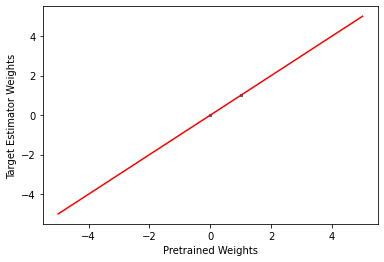

In [ ]:
# s = np.subtract(weights_post, weights_pre) + 1
fig = plt.figure()
plt.scatter(weights_pre, weights_post, s=1)
plt.xlabel('Pretrained Weights')
plt.ylabel('{} Weights'.format(dqn_model))
x = np.linspace(-5,5,100)
plt.plot(x, x, '-r')
plt.show()

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post

# 80K_knock (270~ Wins)
# model = 'models/dqn/random/TEST36'
# Wins: 70/12/24/30/17
# model = 'models/dqn/random/TEST98'
# Wins: 70/22/25/18/13
# model = 'models/dqn/random/TEST97'
# Wins: 70/34/31/30/10
# model = 'models/dqn/random/TEST96'
# Wins: 70/25/21/21/8

# 80K_knock_2K_base (226 Wins)
# model = 'models/dqn/random/TEST95'
# Wins: 72/51/45/43/46
# model = 'models/dqn/random/TEST94'
# Wins: 72/40/28/55/30
# model = 'models/dqn/random/TEST93'
# Wins: 65/5/8/83/0
# model = 'models/dqn/random/TEST92'
# Wins: 77/9/25/40/18
# Wins2: rand_k/self_k/sgr_k
# Wins2: 42/21/18
model = 'models/dqn/random/TEST92'

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:77, P1:923.



#### Post DQN Training

In [ ]:
# Wins: pre/rand/self/sgr/post

# 80K_knock (270~ Wins)
# model = 'models/dqn/random/TEST36'
# Wins: 70/12/24/30/17
# model = 'models/dqn/random/TEST98'
# Wins: 70/22/25/18/13
# model = 'models/dqn/random/TEST97'
# Wins: 70/34/31/30/10
# model = 'models/dqn/random/TEST96'
# Wins: 70/25/21/21/8

# 80K_knock_2K_base (226 Wins)
# model = 'models/dqn/random/TEST95'
# Wins: 72/51/45/43/46
# model = 'models/dqn/random/TEST94'
# Wins: 72/40/28/55/30
# model = 'models/dqn/random/TEST93'
# Wins: 65/5/8/83/0
# model = 'models/dqn/random/TEST92'
# Wins: 77/9/25/40/18
# Wins2: rand_k/self_k/sgr_k
# Wins2: 42/21/18
model = 'models/dqn/random/TEST92'

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:9, P1:991.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:25, P1:975.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:40, P1:960.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:18, P1:982.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:42, P1:958.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:21, P1:979.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:18, P1:982.



## MLP Models vs. SimpleGinRummyAgent (Group Testing)

### DQN - iterate

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# model = 'models/dqn/random/TEST92'
# Wins: 73/7/18/44/7
# Wins2: 38/30/14
# model = 'models/dqn/iterate/1_selfplay'
# Wins: 34/1/39/26/0
# Wins2: 26/34/20
# model = 'models/dqn/iterate/2_random'
# Wins: 5/0/0/1/1
# Wins2: 1/3/2
# model = 'models/dqn/iterate/3_selfplay'
# Wins: 0/0/0/1/0
# Wins2: 1/1/1

# model = 'models/dqn/random/TEST92'
# model = 'models/dqn/iterate/1_selfplay'
# model = 'models/dqn/iterate/2_random'
model = 'models/dqn/iterate/3_selfplay'

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:1, P1:999.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:1, P1:999.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:1, P1:999.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:1, P1:999.



### DQN - rewards

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:
# model = 'models/dqn/rewards/payoff_v6'
# Wins: 78/1/60/72/1
# Wins2: 69/79/69
# model = 'models/dqn/rewards/payoff_v7'
# Wins: 68/71/73/73/0
# Wins2: 74/52/61
model = 'models/dqn/rewards/payoff_v8'
# Wins: 66/0/60/57/1
# Wins2: 66/70/79

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:66, P1:934.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:60, P1:940.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:57, P1:943.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:1, P1:999.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:66, P1:934.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:70, P1:930.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:79, P1:921.



## MLP Models vs. SimpleGinRummyAgent (Knock Layer)

### DQN - knock layer (left in)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:
# model = 'models/dqn/knockLayer/knock_point2'
# Wins: 12/1/9/10/10
# Wins2: 15/15/14
# model = 'models/dqn/knockLayer/knock_point02'
# Wins: 18/18/3/14/20
# Wins2: 17/16/17
model = 'models/dqn/knockLayer/knock_point002'
# Wins: 29/15/14/20/13
# Wins2: 20/14/11

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
knock_layer = True
agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:40, P1:960.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:15, P1:985.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:14, P1:986.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:20, P1:980.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:13, P1:987.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:20, P1:980.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:14, P1:986.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:11, P1:989.



### DQN - knock layer (removed)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:
# model = 'models/dqn/knockLayer/knock_point2'
# Wins: 62/0/1/2/0
# Wins2: 59/56/61
model = 'models/dqn/knockLayer/knock_point02'
# Wins: 60/0/0/3/0
# Wins2: 70/77/74
# model = 'models/dqn/knockLayer/knock_point002'
# Wins: 3/7/5/4/3
# Wins2: 3/3/2

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]
batch_norm = False
knock_layer = False
top_layer = True
agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:3, P1:997.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:7, P1:993.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:5, P1:995.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:4, P1:996.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:3, P1:997.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:3, P1:997.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:2, P1:998.



## MLP Models vs. SimpleGinRummyAgent (Top Layer [removed])

### DQN - top layer (Random)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer/base'
# Wins: 269/256/280/262/281
# Wins2: 281/275/269
# model = 'models/dqn/topLayer/base_unfrozen'
# Wins: 273/218/191/263/206
# Wins2: 266/260/258

# top_layer = True
# model = 'models/dqn/topLayer/topLayer_copy'
# Wins: 62/0/0/88/0
# Wins2: 76/60/53

# knock_layer = True
# top_layer = False
# model = 'models/dqn/topLayer/base_knock_point002'
# Wins: 266/290/264/277/267
# Wins2: 277/264/274
# model = 'models/dqn/topLayer/base_knock_point02'
# Wins: 277/286/284/291/300
# Wins2: 275/251/293
# model = 'models/dqn/topLayer/base_knock_point2'
# Wins: 243/265/287/281/283
# Wins2: 282/271/257
# model = 'models/dqn/topLayer/base_knock_2'
# Wins: 13/8/11/13/10
# Wins2: 14/12/17

knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer/base_payoffv2'
# Wins: 278/266/291/283/288
# Wins2: 307/260/272
# model = 'models/dqn/topLayer/base_payoffv3'
# Wins: 302/240/266/283/287
# Wins2: 270/250/272
model = 'models/dqn/topLayer/base_payoffv4'
# Wins: 271/271/277/277/301
# Wins2: 298/287/264

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:271, P1:729.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:271, P1:729.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:277, P1:723.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:277, P1:723.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:301, P1:699.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:298, P1:702.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:287, P1:713.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:264, P1:736.



### DQN - top layer (Selfplay)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer_self/base'
# Wins: 270/294/258/286/288
# Wins2: 269/265/288
# model = 'models/dqn/topLayer_self/base_unfrozen'
# Wins:  276/258/289/258/273
# Wins2: 285/295/258

# knock_layer = True
# top_layer = False
# model = 'models/dqn/topLayer_self/base_knock_point002'
# Wins: 284/285/279/260/273
# Wins2: 273/285/263
# model = 'models/dqn/topLayer_self/base_knock_point02'
# Wins:  269/279/281/285/278
# Wins2: 274/260/265
# model = 'models/dqn/topLayer_self/base_knock_point2'
# Wins: 273/290/291/272/239
# Wins2: 274/275/272
# model = 'models/dqn/topLayer_self/base_knock_2'
# Wins: 13/10/14/16/6
# Wins2: 13/11/12

knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer_self/base_payoffv2'
# Wins: 284/276/270/277/268
# Wins2: 293/286/287
# model = 'models/dqn/topLayer_self/base_payoffv3'
# Wins: 281/285/257/242/277
# Wins2: 280/251/285
model = 'models/dqn/topLayer_self/base_payoffv4'
# Wins: 292/277/269/281/292
# Wins2: 287/240/277

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:292, P1:708.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:277, P1:723.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:269, P1:731.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:281, P1:719.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:292, P1:708.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:287, P1:713.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:240, P1:760.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:277, P1:723.



### DQN - top layer (BEST 308W - SGRAgent: base_knock_point002)

In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:308, P1:692.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:295, P1:705.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:538, P1:462.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:494, P1:506.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:525, P1:475.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:482, P1:518.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:505, P1:495.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point002'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:487, P1:513.



### DQN - top layer (BEST 315W - SGRAgent: base_knock_point02)

In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:315, P1:685.



#### run testing

In [ ]:
batch_norm = False
knock_layer = False
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)
# testAgents(agent0,agent1,numGames,verbose=True)
# testAgents(agent0,agent1,1,verbose=True)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:310, P1:690.



In [ ]:
batch_norm = False
knock_layer = False
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)
# testAgents(agent0,agent1,numGames,verbose=True)
# testAgents(agent0,agent1,1,verbose=True)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:329, P1:671.



In [ ]:
batch_norm = False
knock_layer = False # T = Keep, F = Remove
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)

agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

# testAgents(agent0,agent2,1,verbose=True)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:495, P1:505.



In [ ]:
batch_norm = False
knock_layer = False # T = Keep, F = Remove
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)

agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

# testAgents(agent0,agent2,1,verbose=True)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:510, P1:490.



In [ ]:
batch_norm = False
knock_layer = False # T = Keep, F = Remove
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)

agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

# testAgents(agent0,agent2,1,verbose=True)
testAgents(agent0,agent2,numGames*10,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Game ...  1750
Game ...  2000
Game ...  2250
Game ...  2500
Game ...  2750
Game ...  3000
Game ...  3250
Game ...  3500
Game ...  3750
Game ...  4000
Game ...  4250
Game ...  4500
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Game ...  6000
Game ...  6250
Game ...  6500
Game ...  6750
Game ...  7000
Game ...  7250
Game ...  7500
Game ...  7750
Game ...  8000
Game ...  8250
Game ...  8500
Game ...  8750
Game ...  9000
Game ...  9250
Game ...  9500
Game ...  9750
Games Won: P0:4929, P1:5071.



In [ ]:
batch_norm = False
knock_layer = True # T = Keep, F = Remove
knock_layer = False # T = Keep, F = Remove
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,1,verbose=True)

#### run

In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:286, P1:714.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:513, P1:487.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:489, P1:511.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:503, P1:497.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:498, P1:502.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:498, P1:502.



In [ ]:
batch_norm = False
knock_layer = True
top_layer = False
model = 'models/dqn/topLayer_sgr/base_knock_point02'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)

testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:501, P1:499.



### DQN - top layer (SGRAgent)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer_sgr/base'
# Wins: 285/289/287/284/289
# Wins2: 252/270/300
# model = 'models/dqn/topLayer_sgr/base_unfrozen'
# Wins: 289/259/237/260/278
# Wins2: 277/285/292

# knock_layer = True
# top_layer = False
# model = 'models/dqn/topLayer_sgr/base_knock_point002'
# Wins: 291/290/307/274/281
# Wins2: 252/282/266
# model = 'models/dqn/topLayer_sgr/base_knock_point02'
# Wins: 250/277/315/261/295
# Wins2: 292/271/268
# model = 'models/dqn/topLayer_sgr/base_knock_point2'
# Wins: 294/277/253/272/279
# Wins2: 279/283/289
# model = 'models/dqn/topLayer_sgr/base_knock_2'
# Wins: 10/16/10/13/14
# Wins2: 12/12/15

knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer_sgr/base_payoffv2'
# Wins: 285/285/271/256/265
# Wins2: 264/287/273
# model = 'models/dqn/topLayer_sgr/base_payoffv3'
# Wins: 275/246/261/280/278
# Wins2: 265/280/251
model = 'models/dqn/topLayer_sgr/base_payoffv4'
# Wins: 268/275/276/287/298
# Wins2: 281/277/260

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:268, P1:732.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:275, P1:725.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:276, P1:724.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:287, P1:713.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:298, P1:702.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:281, P1:719.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:277, P1:723.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:260, P1:740.



### DQN - top layer (SGRAgent - disable knock layer)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

# no knock layer
batch_norm = False
knock_layer = False
top_layer = False
# model = 'models/dqn/topLayer_sgr/base_knock_point002'
# Wins: 268/275/276/287/298
# Wins2: 281/277/260
# model = 'models/dqn/topLayer_sgr/base_knock_point02'
# Wins: 311/258/294/277/299
# Wins2: 284/270/278
# model = 'models/dqn/topLayer_sgr/base_knock_point2'
# Wins: 293/302/243/295/275
# Wins2: 293/265/265
model = 'models/dqn/topLayer_sgr/base_knock_2'
# Wins: 273/281/283/261/298
# Wins2: 260/256/268

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_layers=[520, 520, 110]

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:304, P1:696.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:295, P1:705.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:294, P1:706.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:295, P1:705.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:302, P1:698.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:304, P1:696.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:304, P1:696.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:304, P1:696.



### DQN - SGRAgent additional testing

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers=[520, 520, 110]

# model = 'models/dqn/sgr_testing/small_lr_large_epsd'
# Wins: 281/271/282/292/253
# Wins2: 301/285/271
# model = 'models/dqn/sgr_testing/2HL_2kbase'
# Wins: 230/242/292/252/230
# Wins2: 255/260/234

mlp_layers = [520, 520, 260, 110]
model = 'models/dqn/sgr_testing/3HL'
# Wins: 281/268/269/293/254
# Wins2: 290/256/244

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:283, P1:717.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:276, P1:724.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:241, P1:759.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:268, P1:732.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:276, P1:724.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:251, P1:749.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:265, P1:735.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:273, P1:727.



### DQN - SGRAgent additional testing2

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers=[520, 520, 110]

model = 'models/dqn/sgr_testing/small_lr_small_batch'
# Wins: 
# Wins2:

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:333, P1:667.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:327, P1:673.



#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers=[520, 520, 110]

model = 'models/dqn/sgr_testing/small_lr_small_batch'
# Wins: 
# Wins2:

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:274, P1:726.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:333, P1:667.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:305, P1:695.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:284, P1:716.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:282, P1:718.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:317, P1:683.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:304, P1:696.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:297, P1:703.



### DQN - SGRAgent additional testing (4HL)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers = [520, 1040, 1040, 520, 110]
# model = 'models/dqn/sgr_testing/4HL'
# Wins: 208/189/195/205/195
# Wins2: 193/210/202
model = 'models/dqn/sgr_testing/4HL_unfrozen'
# Wins: 
# Wins2: 

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:208, P1:792.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:189, P1:811.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:195, P1:805.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:205, P1:795.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:196, P1:804.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:193, P1:807.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:210, P1:790.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:202, P1:798.



### DQN - SGRAgent additional testing (2HL_160K)

In [ ]:
batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]
knock_layer = True # Include Knock layer
model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point2'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent1 = SimpleGinRummyPlayer()

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:332, P1:668.



In [ ]:
batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]
knock_layer = True # Include Knock layer
model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent1 = SimpleGinRummyPlayer()

agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:357, P1:643.



### DQN - SGRAgent additional testing (2HL_160K)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers = [520, 520, 110]
# model = 'models/dqn/sgr_testing/2HL_160k_6k'
# Wins: 299/248/274/276/255
# Wins2: 304/285/305

# knock_layer = False # No Knock layer
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point002'
# Wins: 297/285/289/314/253
# Wins2: 315/320/294
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point02'
# Wins: 318/236/256/292/243
# Wins2: 300/315/292
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point2'
# Wins: 306/293/275/268/255
# Wins2: 304/327/300
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8'
# Wins: 309/296/315/307/276
# Wins2: 306/309/307

# knock_layer = True # Include Knock layer
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point002'
# Wins: 308/292/281/284/247
# Wins2: 300/283/298
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point02'
# Wins: 310/257/258/273/241
# Wins2: 290/300/304
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point2'
# Wins: 307/258/297/294/258
# Wins2: 313/308/332
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8'
# Wins: 347/327/346/330/320
# Wins2: 333/357/306

# knock_layer = False # No Knock layer
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8_payoff_v2'
# Wins: 297/259/287/317/246
# Wins2: 310/307/18
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8_payoff_v9'
# Wins: 308/318/302/289/208
# Wins2: 316/323/305

knock_layer = True # Include Knock layer
# model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8_payoff_v2'
# Wins: 362/329/332/349/321
# Wins2: 342/306/323
model = 'models/dqn/sgr_testing/2HL_160k_6k_knock_point8_payoff_v9'
# Wins: 322/327/323/306/308
# Wins2: 334/326/338

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:322, P1:678.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:327, P1:673.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:323, P1:677.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:306, P1:694.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:308, P1:692.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:334, P1:666.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:326, P1:674.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:338, P1:662.



### DQN - SGRAgent additional testing (2HL_wide_160K_6k)

In [ ]:
batch_norm = False
knock_layer = False
top_layer = False
mlp_layers = [1040, 1040, 110]
model = 'models/dqn/sgr_testing/2HL_wide_160k_6k'
numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:358, P1:642.



### DQN - SGRAgent additional testing (2HL_wide_160K_6k)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers = [1040, 1040, 110]
# model = 'models/dqn/sgr_testing/2HL_wide_160k_6k'
# Wins: 330/314/271/329/302
# Wins2: 358/343/344

top_layer = True
model = 'models/dqn/sgr_testing/2HL_wide_160k_6k_toplayer'
# Wins: 174/17/12/43/0
# Wins2: 152/4/169

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:174, P1:826.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:17, P1:983.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:12, P1:988.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:43, P1:957.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:152, P1:848.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:4, P1:996.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:169, P1:831.



### DQN - SGRAgent additional testing (stack layers 2HL_160K_6k)

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
knock_layer = False
top_layer = False
mlp_layers = [1040, 520, 110]
# model = 'models/dqn/sgr_testing/2HL_160k_6k_stackLayers'
# Wins: 241/216/238/205/184
# Wins2: 225/216/220
model = 'models/dqn/sgr_testing/2HL_160k_6k_stackLayers_unfrozen'
# Wins: 228/61/75/198/62
# Wins2: 209/201/204

# mlp_layers = [1040, 1040, 110]
# model = 'models/dqn/sgr_testing/2HL_160k_6k_stackLayers2'
# Wins: 227/198/253/211/201
# Wins2: 264/230/241

# mlp_layers = [1560, 520, 110]
# model = 'models/dqn/sgr_testing/2HL_160k_6k_stackLayers_3wide'
# Wins: 204/187/184/198/149
# Wins2: 161/188/190

# mlp_layers = [1560, 1560, 110]
# model = 'models/dqn/sgr_testing/2HL_160k_6k_stackLayers_3wide2'
# Wins: 204/187/184/198/149
# Wins2: 161/188/190

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:228, P1:772.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:61, P1:939.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:75, P1:925.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:198, P1:802.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:62, P1:938.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:209, P1:791.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:201, P1:799.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:204, P1:796.



# Test Agents

## MLP Models vs. SimpleGinRummyAgent (Current Batch)

### DQN - SGRAgent with knock layers + BS Testing (Best Models)

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Game ...  750
Games Won: P0:510, P1:490.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Game ...  1750
Games Won: P0:1015, P1:985.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Game ...  1750
Game ...  2000
Game ...  2250
Game ...  2500
Game ...  2750
Game ...  3000
Game ...  3250
Game ...  3500
Game ...  3750
Game ...  4000
Game ...  4250
Game ...  4500
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Max Turns exceeded, restart
Game ...  6000
Game ...  6250
Game ...  6500
Game ...  6750
Game ...  7000
Game ...  7250
Game ...  7500
Game ...  7750
Max Turns exceeded, restart
Game ...  8000
Max Turns exceeded, restart
Game ...  8250
Game ...  8500
Game ...  8750
Game ...  9000
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  9250
Game ...  9500
Game ...  9750
Games Won: P0:4991, P1:5009.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Game ...  750
Games Won: P0:521, P1:479.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Game ...  1750
Game ...  2000
Game ...  2250
Game ...  2500
Game ...  2750
Game ...  3000
Game ...  3250
Game ...  3500
Game ...  3750
Game ...  4000
Game ...  4250
Game ...  4500
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Game ...  6000
Game ...  6250
Game ...  6500
Game ...  6750
Game ...  7000
Game ...  7250
Game ...  7500
Game ...  7750
Game ...  8000
Game ...  8250
Game ...  8500
Game ...  8750
Game ...  9000
Game ...  9250
Game ...  9500
Game ...  9750
Games Won: P0:5327, P1:4673.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Max Turns exceeded, restart
Game ...  1750
Game ...  2000
Game ...  2250
Game ...  2500
Game ...  2750
Game ...  3000
Game ...  3250
Game ...  3500
Game ...  3750
Max Turns exceeded, restart
Game ...  4000
Game ...  4250
Game ...  4500
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Game ...  6000
Game ...  6250
Game ...  6500
Game ...  6750
Game ...  7000
Game ...  7250
Game ...  7500
Game ...  7750
Game ...  8000
Max Turns exceeded, restart
Game ...  8250
Game ...  8500
Game ...  8750
Game ...  9000
Max Turns exceeded, restart
Game ...  9250
Max Turns exceeded, restart
Game ...  9500
Game ...  9750
Games Won: P0:5331, P1:4669.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Game ...  750
Games Won: P0:537, P1:463.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Game ...  1750
Game ...  2000
Game ...  2250
Game ...  2500
Game ...  2750
Game ...  3000
Game ...  3250
Game ...  3500
Game ...  3750
Game ...  4000
Game ...  4250
Game ...  4500
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Game ...  6000
Game ...  6250
Game ...  6500
Game ...  6750
Game ...  7000
Game ...  7250
Game ...  7500
Game ...  7750
Game ...  8000
Game ...  8250
Game ...  8500
Game ...  8750
Game ...  9000
Game ...  9250
Game ...  9500
Game ...  9750
Games Won: P0:5179, P1:4821.



In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
knock_layer = True
model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/347/362/355/343

numGames = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Game ...  250
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Game ...  750
Game ...  1000
Game ...  1250
Game ...  1500
Max Turns exceeded, restart
Game ...  1750
Game ...  2000
Game ...  2250
Game ...  2500
Game ...  2750
Game ...  3000
Game ...  3250
Game ...  3500
Game ...  3750
Max Turns exceeded, restart
Game ...  4000
Game ...  4250
Game ...  4500
Max Turns exceeded, restart
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Max Turns exceeded, restart
Game ...  6000
Game ...  6250
Game ...  6500
Max Turns exceeded, restart
Game ...  6750
Game ...  7000
Game ...  7250
Game ...  7500
Game ...  7750
Game ...  8000
Game ...  8250
Game ...  8500
Game ...  8750
Game ...  9000
Max Turns exceeded, restart
Game ...  9250
Max Turns exceeded, restart
Game ...  9500
Game ...  9750
Games Won: P0:5316, P1:4684.



### DQN - SGRAgent with knock layers + BS Testing

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# knock layer, bias = 1, frozen layers
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test5'
# Wins: 304/302/308/314/306
# Wins2: 308/304/304
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test5'
# Wins: 335/343/358/343/371
# Wins2: 337/335/335

# knock layer, bias = 1, frozen layers, trained on selfplay
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test6'
# Wins: 304/251/192/297/216
# Wins2: 304/304/304
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test6'
# Wins: 
# Wins2:


# top layer and knock layer, bias = 1, frozen layers
# top_layer = True
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test7'
# Wins: 
# Wins2:
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test7'
# Wins: 
# Wins2:


# frozen layers
# BS = 2048
# top_layer = False
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test8'
# Wins: 
# Wins2:

# knock layer, bias = 1, frozen layers
# BS = 2048
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test9'
# Wins: 304/304/304/304/304
# Wins2: 304/304/304
# knock_layer = True
# model = 'models/dqn/selfplay/test9'
# Wins: 335/335/335/335
# Wins2: 335/335/335

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:359, P1:641.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:355, P1:645.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:350, P1:650.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:348, P1:652.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:352, P1:648.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:347, P1:653.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:349, P1:651.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:354, P1:646.



### DQN - test5 additional training (Best Models)

In [58]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# test5 -> unfrozen knock layer
knock_layer = True
model = 'models/dqn/sgr_testing2/test11'
# Wins: 371/373/372/368/374
# Wins2: 371/371/371

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Max Turns exceeded, restart
Game ...  250
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  750
Max Turns exceeded, restart
Games Won: P0:504, P1:496.



In [59]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# test5 -> unfrozen knock layer
knock_layer = True
model = 'models/dqn/sgr_testing2/test11'
# Wins: 371/373/372/368/374
# Wins2: 371/371/371

numGames = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
agent2 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent2.loadModel(qnet)
testAgents(agent0,agent2,numGames,verbose=False)

Load Model
Load Model
Game ...  0
Max Turns exceeded, restart
Game ...  250
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  500
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  750
Max Turns exceeded, restart
Game ...  1000
Game ...  1250
Max Turns exceeded, restart
Game ...  1500
Max Turns exceeded, restart
Game ...  1750
Game ...  2000
Game ...  2250
Max Turns exceeded, restart
Game ...  2500
Max Turns exceeded, restart
Game ...  2750
Game ...  3000
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  3250
Game ...  3500
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  3750
Max Turns exceeded, restart
Game ...  4000
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  4250
Max Turns exceeded, restart
Max Turns exceeded, restart
Game ...  4500
Game ...  4750
Game ...  5000
Game ...  5250
Game ...  5500
Game ...  5750
Max Turns exceeded, restart
Game ...  6000
Max Turns exceeded, restart
Game ...  6250
Game .

### DQN - test5 additional training

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
mlp_layers = [520, 520, 110]

# test5 -> knock layer = 0.8
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test10'
# Wins: 306/306/306/306/306
# Wins2: 306/306/306
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test10'
# Wins: 359/358/359/359/358
# Wins2: 359/359/359


# test5 -> unfrozen knock layer
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test11'
# Wins: 306/306/306/306/306
# Wins2: 306/306/306
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test11'
# Wins: 371/373/372/368/374
# Wins2: 371/371/371


# test5 -> knock layer = 0.8 = test10 -> knock layer = 0.6
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test12'
# Wins: 306/306/308/307/308
# Wins2: 307/307/306
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test12'
# Wins: 351/351/352/352/352
# Wins2: 352/352/251


# test5 -> knock layer = 0.8 + unfrozen knock layer
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test13'
# Wins: 306/306/306/306/306
# Wins2: 306/306/306
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test13'
# Wins: 359/355/350/348/352
# Wins2: 347/349/354

# test5 -> knock layer = 0.8 + unfrozen knock layer (and top)
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test14'
# Wins: 306/271/293/280/275
# Wins2: 297/297/295
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test14'
# Wins: 359/304/337/306/308
# Wins2: 321/319/330


# test5 -> knock layer = 0.8 + unfrozen knock layer (and top), larger LR
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test15'
# Wins: 306/256/259/268/250
# Wins2: 236/241/243
# knock_layer = True
# model = 'models/dqn/sgr_testing2/test15'
# Wins: 359/286/156/173/156
# Wins2: 167/164/184


# test5 BUT unfrozen biases
# knock_layer = False
# model = 'models/dqn/sgr_testing2/test16'
# Wins: 304/323/297/291/286
# Wins2: 304/304/304
knock_layer = True
model = 'models/dqn/sgr_testing2/test16'
# Wins: 335/309/321/302/299
# Wins2: 335/335/335

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:335, P1:665.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:309, P1:691.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:321, P1:679.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:302, P1:698.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:299, P1:701.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:335, P1:665.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:335, P1:665.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:335, P1:665.



### DQN - identity training

#### Pre Training

In [ ]:
# Wins: pre/rand/self/sgr/post
# Wins2: rand_k/self_k/sgr_k
# Wins: 
# Wins2:

batch_norm = False
top_layer = False
knock_layer = True
mlp_layers = [520, 520, 110]

# both identity and bias trained layer
# model = 'models/dqn/identity/test1'
# Wins: 261/240/219/224/220
# Wins2: 258/239/251

# only identity layer with knock layer bias
# model = 'models/dqn/identity/test2'
# Wins: 314/301/305/297/278
# Wins2: 314/314/314

# both identity and bias trained layer, clamped to [-0.5, 0.5]
# model = 'models/dqn/identity/test3'
# Wins: 172/191/194/185/191
# Wins2: 179/180/199

# only identity layer (10% data) with knock layer bias, clamped to [-0.5, 0.5]
# model = 'models/dqn/identity/test4'
# Wins: 1/26/29/27/34
# Wins2: 1/1/1

# both identity and bias trained layer (5K samples), clamped to [-0.5, 0.5]
model = 'models/dqn/identity/test5'
# Wins: 0/0/0/0/0
# Wins2: 0/0/0

# only identity layer (5K samples) with knock layer bias, clamped to [-0.5, 0.5]
# model = 'models/dqn/identity/test6'
# Wins: 0/0/0/0/0
# Wins2: 0/0/0

numGames = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

agent1 = SimpleGinRummyPlayer()

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_pretrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



#### Post DQN Training

In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_posttrain.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_rand_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_self_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



In [ ]:
agent0 = MLPGinRummyPlayer()
checkpoint = torch.load('{}/model_sgr_knock.pth'.format(model), map_location=device)
qnet = EstimatorNetwork(mlp_layers, batch_norm, knock_layer, top_layer).to(device)
qnet.load_state_dict(load_checkpoint(checkpoint['dqn_q_estimator']))
agent0.loadModel(qnet)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
Game ...  0
Game ...  250
Game ...  500
Game ...  750
Games Won: P0:0, P1:1000.



## Test

### Single Game Verbose

In [ ]:
numGames = 1
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST2/model_pretrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=True)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Player 0 is dealt [5C, 8H, KH, 8C, 4S, KS, 2S, TD, 5H, 2D].

Player 1 is dealt [TH, 9S, 6D, JD, JC, QS, QH, 3C, 3D, 2H].

Player 1 starts.

The initial face up card is 6H.

Player 1 declines 6H.

Update States
Draw new card: 0.019223161
Pickup from discard: 0.019223161
Player 0 declines 6H.

Draw from deck
Player 1 draws KD.

Player 1 discards TH.

Player 1 has [9S, 6D, JD, JC, QS, QH, 3C, 3D, 2H, KD] with 73 deadwood.

Update States
Draw new card: 0.019204292
Pickup from discard: 0.019204292
Draw from deck
Player 0 draws AH.

Update States
Current 

In [ ]:
numGames = 1
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('models/dqn/SGRAgent/TEST2/model_posttrain.pth', map_location=device)
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=True)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Player 0 is dealt [4H, 9H, 5H, 6S, AS, 2H, 7D, KH, QS, 7H].

Player 1 is dealt [4S, 6C, 2C, AC, 5C, TS, 6H, TC, 9S, 4D].

Player 1 starts.

The initial face up card is 2S.

Player 1 declines 2S.

Update States
Draw new card: 0.19178025
Pickup from discard: 0.21570157
drawFaceUp (Pickup discarded card)
Player 0 draws 2S.

Update States
Current Hand: [4H, 9H, 5H, 6S, AS, 2H, 7D, KH, QS, 7H, 2S]
Discard QS | D: QS | K: KH | 17
MAX:0.2130, 0.0000
Discard Action
Player 0 discards QS.

Player 0 has [4H, 9H, 5H, 6S, AS, 2H, 7D, KH, 7H, 2S] with 53 deadwood

### Debugging

In [ ]:
a = GinRummyGame(agent0, agent1)

In [ ]:
a.players

In [ ]:
numGames = 1000
agent0 = RandGinRummyPlayer()
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
testAgents(agent0,agent1,numGames,verbose=False)

### QNet

In [ ]:
numGames = 1
numGames = 2000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/TEST5/model_posttrain.pth', map_location=device)
mlp_layers=[520, 110]
# mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/TEST9/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/TEST10/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

In [ ]:
numGames = 100
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/TEST9/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent0.loadModel(qnet)

agent1 = MLPGinRummyPlayer()
# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/TEST10/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])
agent1.loadModel(qnet)

states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

In [ ]:
numGames = 1000
agent0 = MLPGinRummyPlayer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
checkpoint = torch.load('models/dqn/selfplay/TEST2/model_posttrain.pth', map_location=device)
# mlp_layers=[520, 110]
mlp_layers=[520, 520, 110]
batch_norm = False
qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

agent0.loadModel(qnet)
# print(model_name)
agent1 = SimpleGinRummyPlayer()
states, actions = [], []
# testAgents(agent0,agent1,numGames,verbose=True)
testAgents(agent0,agent1,numGames,verbose=False)

Load Model
EstimatorNetwork(
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=260, out_features=520, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=520, out_features=520, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=520, out_features=110, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=110, out_features=110, bias=True)
    (8): Softmax(dim=1)
  )
)
Game ...  0
Game ...  100
Game ...  200
Game ...  300
Game ...  400
Game ...  500
Game ...  600
Game ...  700
Game ...  800
Game ...  900
Games Won: P0:2, P1:998.



# Loading Agent Model Testing

In [ ]:
state = 'all'
action = 'all'
model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)

In [ ]:
state_s = 'apbd'
action_a = 'knock'
data_pth = '{}/data/{}/{}'.format(pth,state_s,action_a)
states = np.load('{}/s_2k.npy'.format(data_pth))
actions = np.load('{}/a_2k.npy'.format(data_pth))

## Agent

In [ ]:
agent = MLPGinRummyPlayer()

In [ ]:
state_s = 'all'
action_a = 'all'
agent.loadModel(torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state_s,action_a,model_name), map_location=device))

Load Model


In [ ]:
# input = np.expand_dims(states[0],axis=0)
# prob = agent.model(torch.from_numpy(input).type(torch.FloatTensor))
# action = prob.detach().numpy().reshape(-1)
# action[6:58]*np.zeros(52)
# # agent.model(np.expand_dims(,axis=0))

In [ ]:
deck = Deck.getShuffle(random.randrange(10 ** 8))
hands = []
hands.extend([[], []])
hands[0] = []
hands[1] = []
for i in range(2 * GinRummyGame.HAND_SIZE):
    hands[i % 2] += [deck.pop()]
agent.startGame(0, 0, hands[0]);

In [ ]:
agent.updateStates(states[-1])

Update States


In [ ]:
c = Deck.strCardMap['AC']
agent.willDrawFaceUpCard(c)

Pickup from discard: 5.1510585e-10
Draw new card: 8.215045e-09
Draw Action


True

In [ ]:
agent.playerNum

0

In [ ]:
i = 11
agent.updateStates(states[i])
agent.reportDraw(0, c)
agent.getDiscard()
all_classes[np.argmax(actions[i])]

Update States
6D 89
MAX:0.19825728237628937, 0.7989177107810974
Knock Action


'6D'

In [ ]:
agent.model(torch.from_numpy(np.expand_dims(agent.state, axis=0)).type(torch.FloatTensor).to(device))
# state = np.expand_dims(self.state, axis=0)
# action = self.model(torch.from_numpy(state).type(torch.FloatTensor))

tensor([[1.5613e-08, 1.5413e-08, 5.1511e-10, 8.2150e-09, 2.9999e-08, 1.2821e-09,
         5.5631e-09, 2.5155e-08, 2.7546e-06, 4.5472e-07, 1.0434e-03, 8.9934e-17,
         3.4545e-15, 7.6638e-20, 1.2097e-23, 9.0395e-21, 3.3336e-16, 1.2249e-17,
         1.4306e-13, 1.5554e-08, 5.1269e-08, 1.0969e-08, 7.8594e-07, 7.9670e-12,
         4.4021e-18, 5.8035e-19, 3.2541e-18, 1.2281e-18, 1.5415e-15, 2.9808e-19,
         8.6931e-15, 8.5212e-14, 1.4021e-08, 1.0776e-08, 1.0269e-08, 2.9233e-09,
         6.7081e-11, 1.9826e-01, 8.6911e-15, 1.6958e-20, 6.8392e-18, 3.8210e-16,
         1.5054e-19, 4.5664e-16, 3.2462e-10, 1.5062e-07, 2.1884e-08, 1.1281e-08,
         1.1448e-04, 5.9201e-12, 1.1257e-13, 1.4764e-16, 3.0289e-24, 8.3574e-19,
         7.6238e-17, 3.5383e-14, 8.8625e-20, 1.4193e-20, 2.3093e-07, 1.5752e-07,
         4.3524e-05, 1.8425e-06, 1.4934e-03, 3.1863e-11, 4.4363e-08, 1.9563e-07,
         4.9013e-06, 1.5853e-08, 1.0693e-06, 1.3684e-08, 8.0732e-07, 1.6183e-08,
         2.2061e-05, 9.4124e

## QNet

In [ ]:
class EstimatorNetwork(nn.Module):
    ''' The function approximation network for Estimator
        It is just a series of sigmoid layers. All in/out are torch.tensor
        (OLD) It is just a series of tanh layers. All in/out are torch.tensor
    '''

    def __init__(self, mlp_layers=None, batch_norm=False):
        ''' Initialize the Q network
        Args:
            action_num (int): number of legal actions
            state_shape (list): shape of state tensor
            mlp_layers (list): output size of each fc layer
        '''
        super(EstimatorNetwork, self).__init__()

        self.action_num = 110
        self.state_shape = 260
        self.mlp_layers = mlp_layers
        self.batch_norm = batch_norm

        # build the Q network
        layer_dims = [np.prod(self.state_shape)] + self.mlp_layers
        fc = [nn.Flatten()]
        if batch_norm:
            fc.append(nn.BatchNorm1d(layer_dims[0]))
        for i in range(len(layer_dims)-1):
            fc.append(nn.Linear(layer_dims[i], layer_dims[i+1], bias=True))
            fc.append(nn.Sigmoid())
        fc.append(nn.Linear(layer_dims[-1], self.action_num, bias=True))
        fc.append(nn.Softmax(dim=1))
        self.fc_layers = nn.Sequential(*fc)

    def forward(self, s):
        ''' Predict action values
        Args:
            s  (Tensor): (batch, state_shape)
        '''
        return self.fc_layers(s)

In [ ]:
state_shape = 260
action_num = 110
mlp_layers=[520, 520, 110]
batch_norm = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qnet = EstimatorNetwork(mlp_layers, batch_norm)
qnet = qnet.to(device)

In [ ]:
checkpoint = torch.load('models/dqn/TEST4/model_posttrain.pth', map_location=device)

In [ ]:
qnet.load_state_dict(checkpoint['dqn_q_estimator'])

<All keys matched successfully>

In [ ]:
qnet(torch.from_numpy(np.expand_dims(states[-1], axis=0)).type(torch.FloatTensor).to(device))

tensor([[7.2249e-09, 2.2420e-10, 9.7314e-16, 4.7728e-15, 1.2340e-20, 6.8497e-10,
         5.7679e-02, 3.3210e-02, 1.1054e-01, 2.0988e-02, 1.7701e-02, 6.7780e-03,
         1.2067e-02, 4.0160e-03, 2.8021e-04, 3.1774e-03, 5.9243e-03, 1.0486e-02,
         3.3039e-03, 2.7109e-02, 3.3363e-02, 4.7771e-02, 1.8946e-02, 2.7230e-02,
         9.2067e-03, 3.6598e-03, 2.2502e-03, 9.3831e-03, 7.2180e-03, 2.3893e-03,
         2.6061e-03, 6.0732e-03, 2.8625e-02, 4.8642e-02, 3.8667e-02, 3.7032e-02,
         1.3078e-02, 9.2480e-02, 9.3268e-04, 1.0151e-03, 4.8095e-03, 1.0041e-03,
         5.6105e-03, 2.7269e-03, 3.4772e-03, 3.9008e-02, 4.8259e-02, 3.4264e-02,
         4.3172e-02, 2.0446e-02, 1.8986e-02, 2.4711e-03, 7.2034e-03, 1.0481e-03,
         1.0171e-02, 4.2704e-03, 6.3416e-04, 8.6092e-03, 4.0611e-10, 3.4673e-10,
         1.6277e-10, 1.9494e-10, 3.1402e-10, 1.9318e-10, 2.3830e-10, 1.1181e-10,
         1.1989e-10, 1.7327e-10, 2.8693e-10, 8.1085e-11, 1.4320e-10, 9.0052e-11,
         2.9499e-10, 5.1579e